In [1]:
# Libraries
import pandas as pd
pd.set_option('display.max_colwidth', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

# Loading in the cleaned DF
with open("profiles.pkl",'rb') as fp:
    df = pickle.load(fp)
    

In [4]:
# Instantiating the Scaler 
scaler = MinMaxScaler()
# Scaling the categories then replacing the old values 
df = df[['Bios']].join(pd.DataFrame( scaler.fit_transform(df.drop('Bios',axis=1)), columns=df.columns[1:], index=df.index))

In [5]:
# Instantiating the Vectorizer, experimenting with both
vectorizer = CountVectorizer()
#vectorizer = TfidfVectorizer()

# Fitting the vectorizer to the Bios
x = vectorizer.fit_transform(df['Bios'])

# Creating a new DF that contains the vectorized words
df_wrds = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names())

# Concating the words DF with the original DF
new_df = pd.concat([df, df_wrds], axis=1)

# Dropping the Bios because it is no longer needed in place of vectorization
new_df.drop('Bios', axis=1, inplace=True)

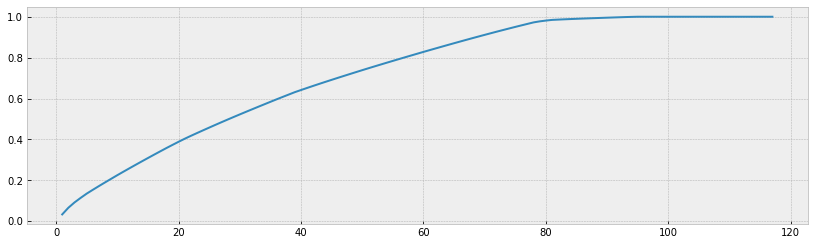

Number features: 74
Total Variance Explained: 0.9502456396954578
0.9426305242520768


In [6]:
# Importing the library
from sklearn.decomposition import PCA

# Instantiating PCA
pca = PCA()

# Fitting and Transforming the DF
df_pca = pca.fit_transform(new_df)

# Plotting to determine how many features should the dataset be reduced to
plt.style.use("bmh")
plt.figure(figsize=(14,4))
plt.plot(range(1,new_df.shape[1]+1), pca.explained_variance_ratio_.cumsum())
plt.show()

# Finding the exact number of features that explain at least 95% of the variance in the dataset
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance>=.95])
n_to_reach_95 = new_df.shape[1] - n_over_95

# Printing out the number of features needed to retain 95% variance
print(f"Number features: {n_to_reach_95}\nTotal Variance Explained: {total_explained_variance[n_to_reach_95]}")

# Reducing the dataset to the number of features determined before
pca = PCA(n_components=n_to_reach_95)

# Fitting and transforming the dataset to the stated number of features and creating a new DF
df_pca = pca.fit_transform(new_df)

# Seeing the variance ratio that still remains after the dataset has been reduced
print(pca.explained_variance_ratio_.cumsum()[-1])

In [7]:
# Setting the amount of clusters to test out
cluster_cnt = [i for i in range(2, 20, 1)]

# Establishing empty lists to store the scores for the evaluation metrics
s_scores = []

db_scores = []

# Looping through different iterations for the number of clusters
for i in cluster_cnt:
    
    # Hierarchical Agglomerative Clustering with different number of clusters
    hac = AgglomerativeClustering(n_clusters=i)
    
    hac.fit(df_pca)
    
    cluster_assignments = hac.labels_
    
    ## KMeans Clustering with different number of clusters
    #k_means = KMeans(n_clusters=i)
    
    #k_means.fit(df_pca)
    
    #cluster_assignments = k_means.predict(df_pca)
    
    # Appending the scores to the empty lists    
    s_scores.append(silhouette_score(df_pca, cluster_assignments))
    
    db_scores.append(davies_bouldin_score(df_pca, cluster_assignments))

Max Value:
Cluster #    Cluster Score
9       0.033426

Min Value:
Cluster #     Cluster Score
18       0.016165


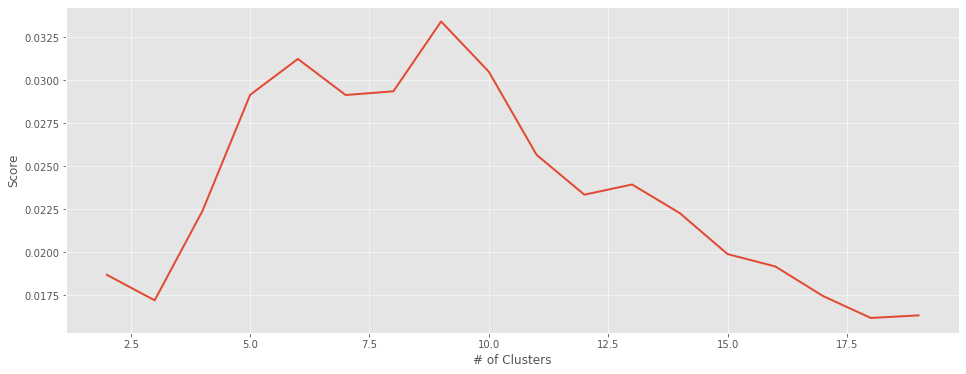

Max Value:
Cluster #    Cluster Score
2       5.228762

Min Value:
Cluster #    Cluster Score
9       4.017302


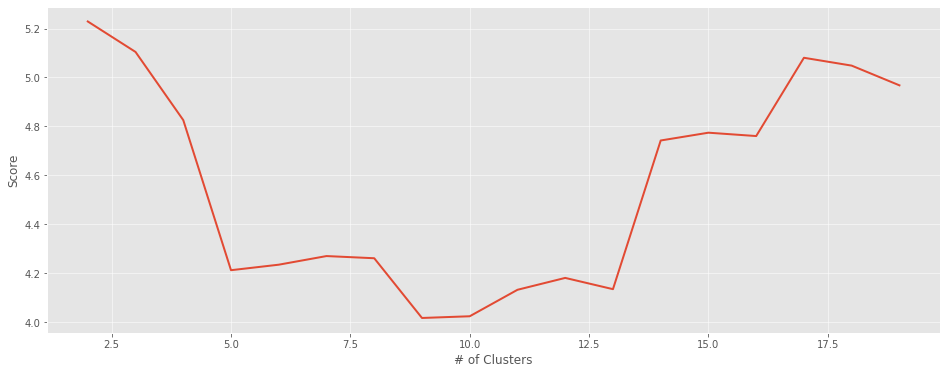

In [8]:
def plot_evaluation(y, x=cluster_cnt):
    """
    Plots the scores of a set evaluation metric. Prints out the max and min values of the evaluation scores.
    """
    
    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y
    
    print('Max Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    
    # Plotting out the scores based on cluster count
    plt.figure(figsize=(16,6))
    plt.style.use('ggplot')
    plt.plot(x,y)
    plt.xlabel('# of Clusters')
    plt.ylabel('Score')
    plt.show()
    
# Running the function on the list of scores
plot_evaluation(s_scores)

plot_evaluation(db_scores)

In [9]:
# Instantiating HAC
hac = AgglomerativeClustering(n_clusters=12)

# Fitting
hac.fit(df_pca)

# Getting cluster assignments
cluster_assignments = hac.labels_

# Unscaling the categories then replacing the scaled values
df = df[['Bios']].join(pd.DataFrame(scaler.inverse_transform(df.drop('Bios', axis=1)), columns=df.columns[1:], index=df.index))

# Assigning the clusters to each profile
df['Cluster #'] = cluster_assignments

# Viewing the dating profiles with cluster assignments
df

,Bios,Movies,TV,Religion,Music,Sports,Books,Politics,Cluster #
0,Typical twitter fanatic. Infuriatingly humble thinker. Lifelong coffee practitioner. Organizer.,5.0,3.0,4.0,1.0,3.0,6.0,7.0,4
1,Web junkie. Analyst. Infuriatingly humble introvert. Food nerd. Lifelong music fanatic. Coffee lover.,7.0,9.0,5.0,1.0,9.0,4.0,0.0,4
2,Avid web maven. Food practitioner. Gamer. Twitter fanatic. Pop culture scholar. Zombie evangelist.,1.0,2.0,6.0,5.0,6.0,5.0,4.0,1
3,Twitteraholic. Extreme web fanatic. Food buff. Infuriatingly humble entrepreneur.,5.0,2.0,7.0,8.0,2.0,6.0,6.0,4
4,Bacon enthusiast. Falls down a lot. Freelance social media fan. Infuriatingly humble introvert.,6.0,6.0,6.0,4.0,3.0,6.0,3.0,4
...,...,...,...,...,...,...,...,...,...
6595,Typical pop culture nerd. Infuriatingly humble internet maven. Alcohol evangelist.,7.0,9.0,0.0,0.0,2.0,2.0,4.0,1
6596,Avid web junkie. Lifelong alcohol guru. Hardcore reader. Award-winning twitter evangelist.,4.0,3.0,6.0,3.0,7.0,7.0,2.0,5
6597,Music ninja. Bacon fanatic. Reader. Total communicator. Unapologetic beer specialist.,1.0,4.0,0.0,4.0,9.0,2.0,5.0,0
6598,Communicator. Bacon lover. Award-winning introvert. Amateur internet ninja.,6.0,2.0,0.0,3.0,8.0,9.0,1.0,0
